In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector
from spacytextblob.spacytextblob import SpacyTextBlob

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [13]:
reviews_path_ba = "data/matched_beer_data/ratings_ba.txt"
reviews_path_rb = "data/matched_beer_data/ratings_rb.txt"
users_path_ba = "data/users_ba.csv"
users_path_rb = "data/users_rb.csv"
breweries_path = "data/matched_beer_data/breweries.csv"
beers_path = "data/matched_beer_data/beers.csv"

In [14]:
states_climate = pd.read_csv("data/states_climate.csv")
states_climate.set_index("State", inplace=True)

# Seeing the world through the lens of beer reviews


Beers are produced and consumed in every part of the world. One can thus wonder how beers around the world are perceived by different cultures. The interest of this project is to look into how beers from each country of production are judged and how specific countries judge others. As a side note, we will finally answer an age-old question : Are German beers actually good ?

On the one hand, we want to explore how a country’s beers are perceived both quantitatively and qualitatively. On the other hand, we will analyze the users’ ratings and look for significant patterns in how distinct countries rate other countries. For both of these analyses, we will dissect both the ratings and reviews to understand the feelings of the users. These findings will also be mapped to their climate to see if there is a correlation between a countries’ beer rating and the climate of said country. 


## 1) Loading data 

- All the pre-processing is done using the functions defined in `data_loader.py`.
- The preprocessing functions are described and documented in `data_loader.py`.
- We use the reviews/ ratings from both BeerAdvocate and RateBeer, and use the matched beers and breweries dataset to make sure that the names of the same beers are identical across the two datasets.
- Those two reviews/ ratings datasets are then merged and joined to the breweries, beers and users datasets to obtain a single complete dataframe of beer reviews.



In [15]:
users_df_ba = get_users_df(users_path_ba)
users_df_rb = get_users_df(users_path_rb)
ba_df = get_reviews_df(reviews_path_ba)
rb_df = get_reviews_df(reviews_path_rb)
breweries_df = get_breweries_df(breweries_path)
beers_df = get_beers_df(beers_path)
beers_df = join_breweries_on_beers(beers_df, breweries_df)
reviews_df = merge_reviews(ba_df, rb_df, beers_df, users_df_ba, users_df_rb)

## Is focusing on the US a feasible idea ?

### Numerical reviews

Here we want only the revieys of users in the US and then drop the beers with less than 10 reviews and see how many reviews per state there is after it.

C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_20820\3277178512.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_users_ratings[columns_compare] = us_users_ratings[columns_compare].astype(float)
C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_20820\3277178512.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_users_ratings["user_location"] = [name.replace("United States, ", "") for name in us_users_ratings["user_location"]]
C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_20820\3277178512.py:1

 Percentage of ratings left:  97.43390674692388 %


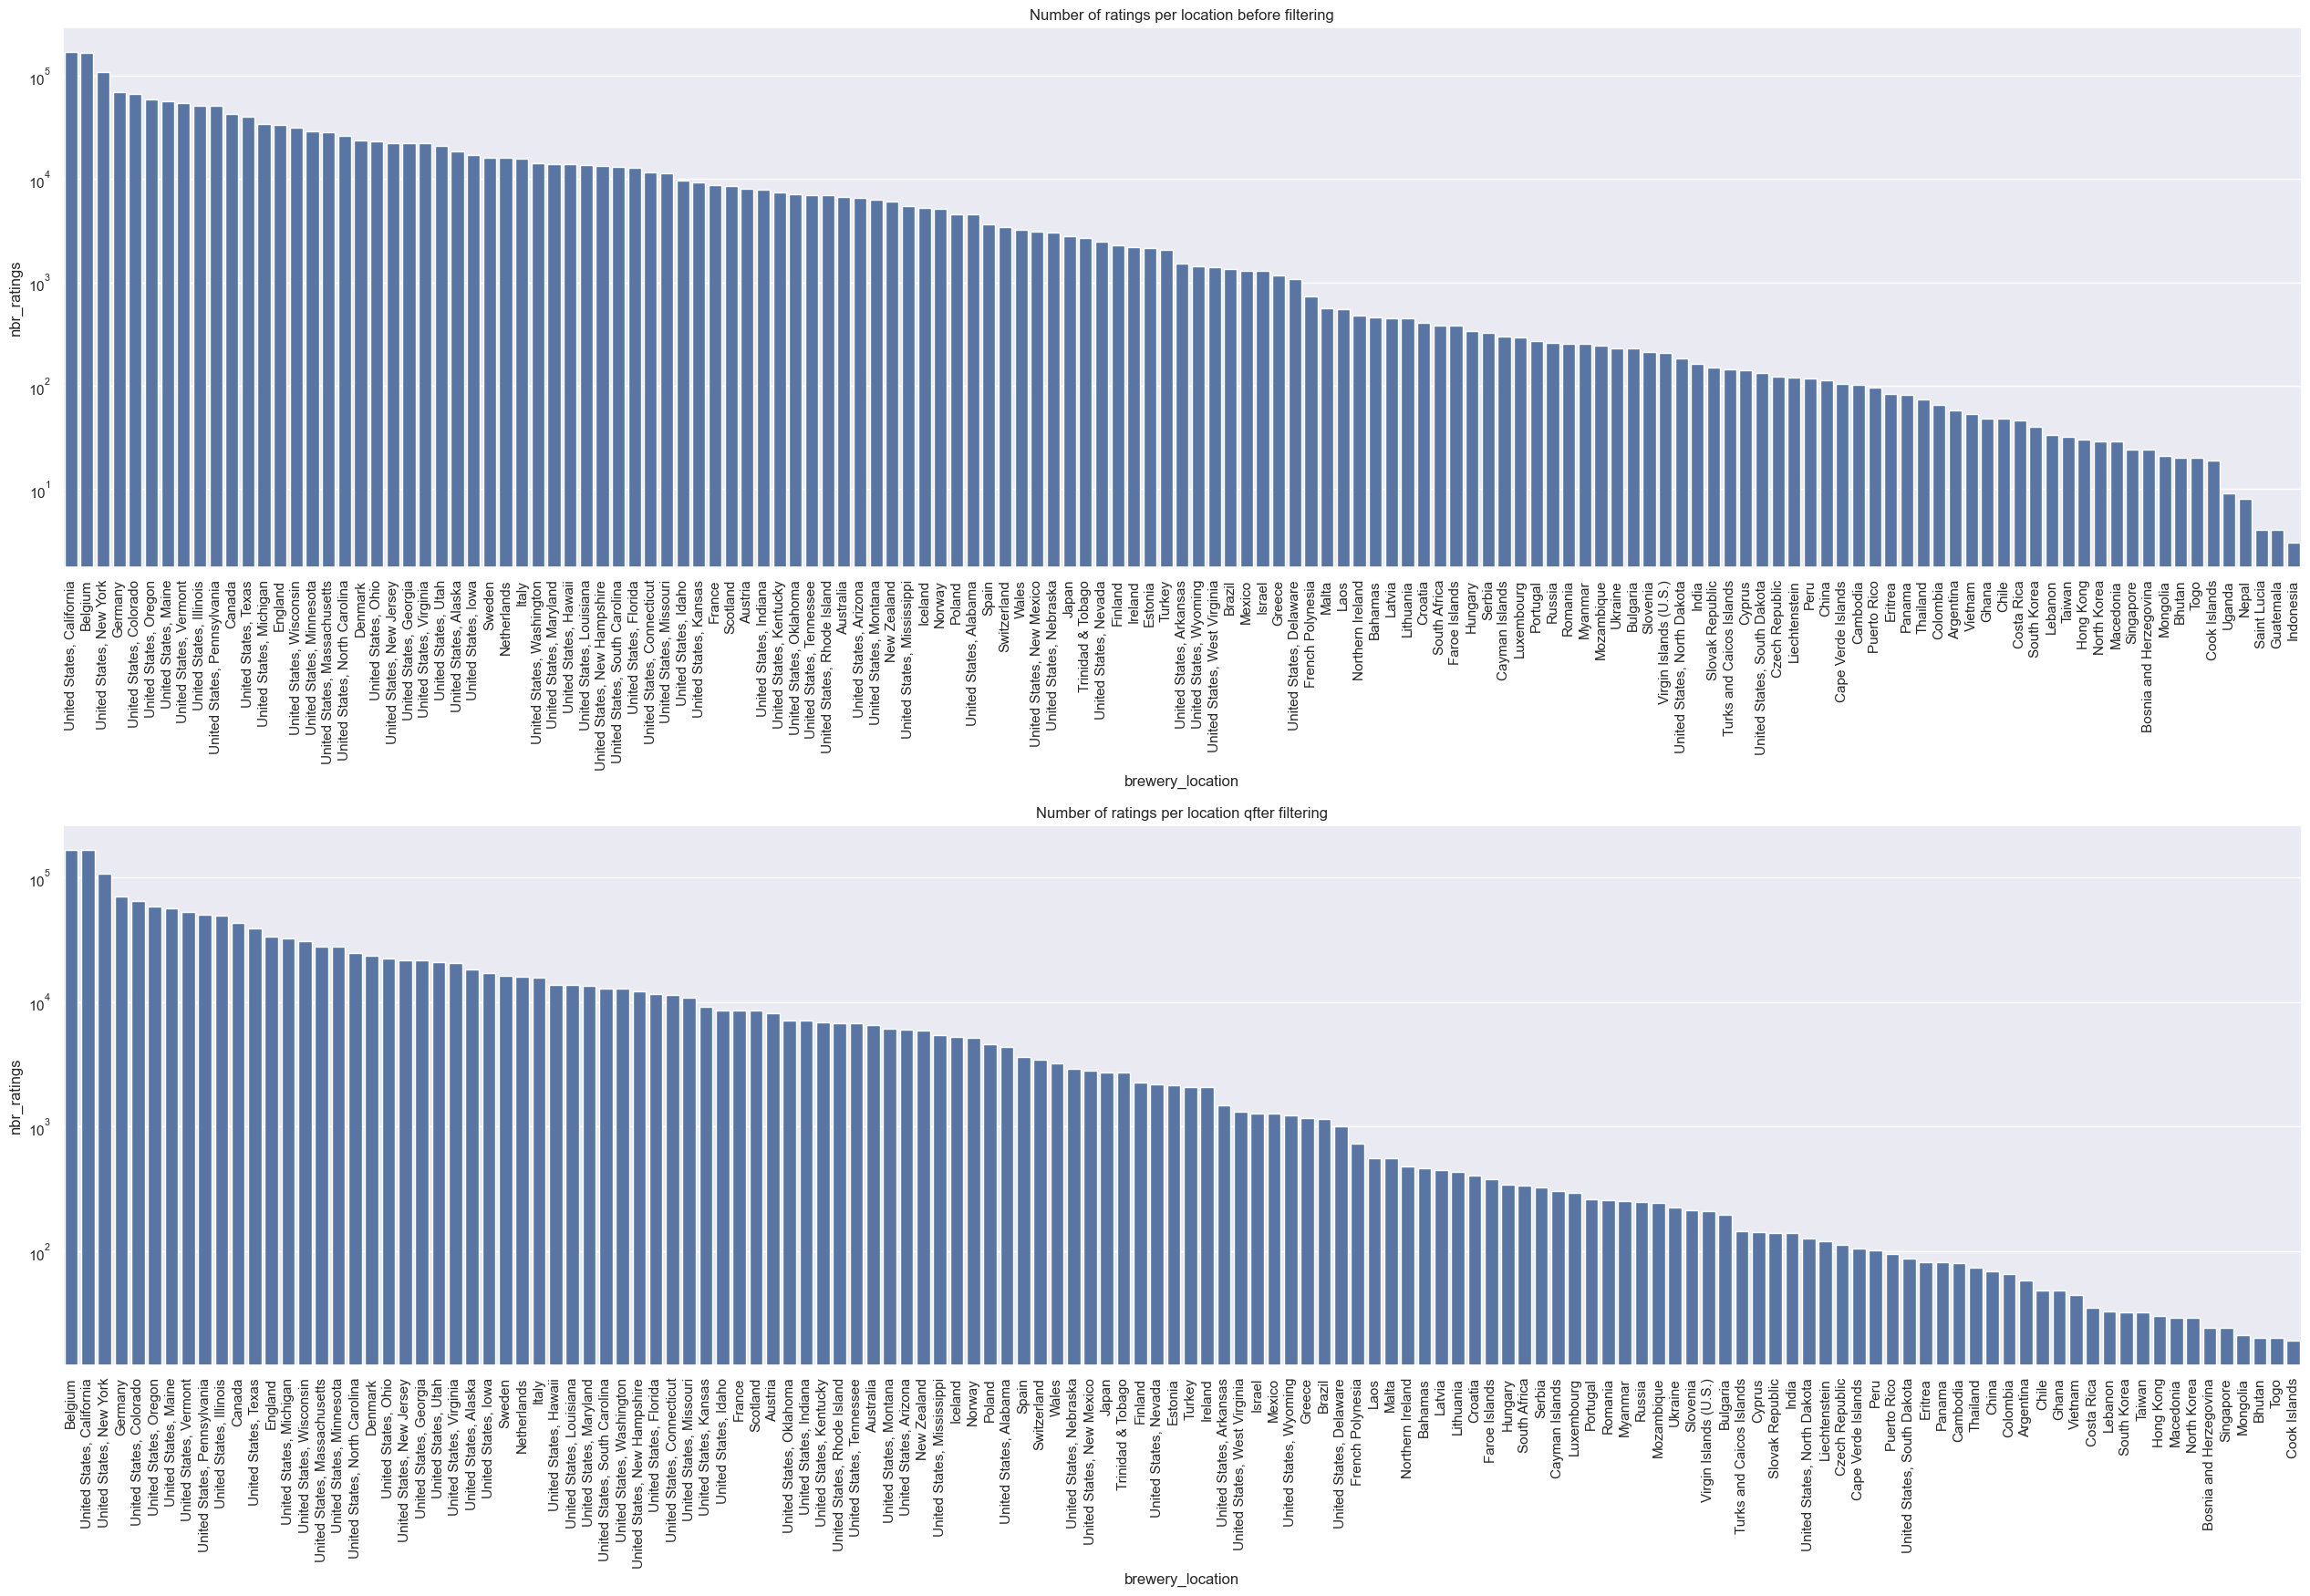

In [16]:
pd.set_option("display.max_columns", None)

world_ratings = reviews_df.copy()
world_ratings["nbr_ratings"] = world_ratings["nbr_ratings_rb"] + world_ratings["nbr_ratings_ba"]
#drop rows where user_location is NaN   
world_ratings = world_ratings.dropna()

#create df with only users from the us
us_users_ratings = world_ratings[world_ratings["user_location"].str.contains("United States")]

#convert ratings from string to float
columns_compare = ["aroma", "appearance", "palate", "taste", "overall", "rating"]
us_users_ratings[columns_compare] = us_users_ratings[columns_compare].astype(float)                   

us_users_ratings["user_location"] = [name.replace("United States, ", "") for name in us_users_ratings["user_location"]]

#add climate column where climate is the climate of the state the user is from
us_users_ratings["climate"] = us_users_ratings["user_location"].map(states_climate["Climate"])

unique_beers = us_users_ratings[["beer_id", "nbr_ratings", "brewery_location"]].copy().drop_duplicates()
total_ratings = unique_beers["nbr_ratings"].sum()

unique_beers = unique_beers.groupby("brewery_location")["nbr_ratings"].sum().sort_values(ascending=False).reset_index()

fig, axs = plt.subplots(2,1,figsize=(30, 20))
fig.tight_layout(pad = 15.0)
sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nbr_ratings", data=unique_beers, orient="v", ax=axs[0])
axs[0].tick_params(axis="x", rotation=90)
axs[0].set_title("Number of ratings per location before filtering")
axs[0].set(yscale="log")


#only keep beers with more than 10 ratings
us_users_ratings = us_users_ratings[us_users_ratings["nbr_ratings"] > 10]

beers_left = us_users_ratings[["beer_id","nbr_ratings", "brewery_location"]].copy().drop_duplicates()

beers_left = beers_left.groupby("brewery_location")["nbr_ratings"].sum().sort_values(ascending=False).reset_index()

ratings_left = beers_left["nbr_ratings"].sum()
print(" Percentage of ratings left: ", ratings_left / total_ratings * 100, "%")

beers_left["Percentage of ratings"] = beers_left["nbr_ratings"] / beers_left["nbr_ratings"].sum() * 100

sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nbr_ratings", data=beers_left, orient="v", ax=axs[1])
axs[1].set_title("Number of ratings per location qfter filtering")
axs[1].tick_params(axis="x", rotation=90)
plt.yscale("log")

### Textual reviews

C:\Users\JPMONIATTE\AppData\Local\Temp\ipykernel_20820\1907540036.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_users_txt["user_location"] = [name.replace("United States, ", "") for name in us_users_txt["user_location"]]


 Percentage of ratings left:  81.22244732746941 %


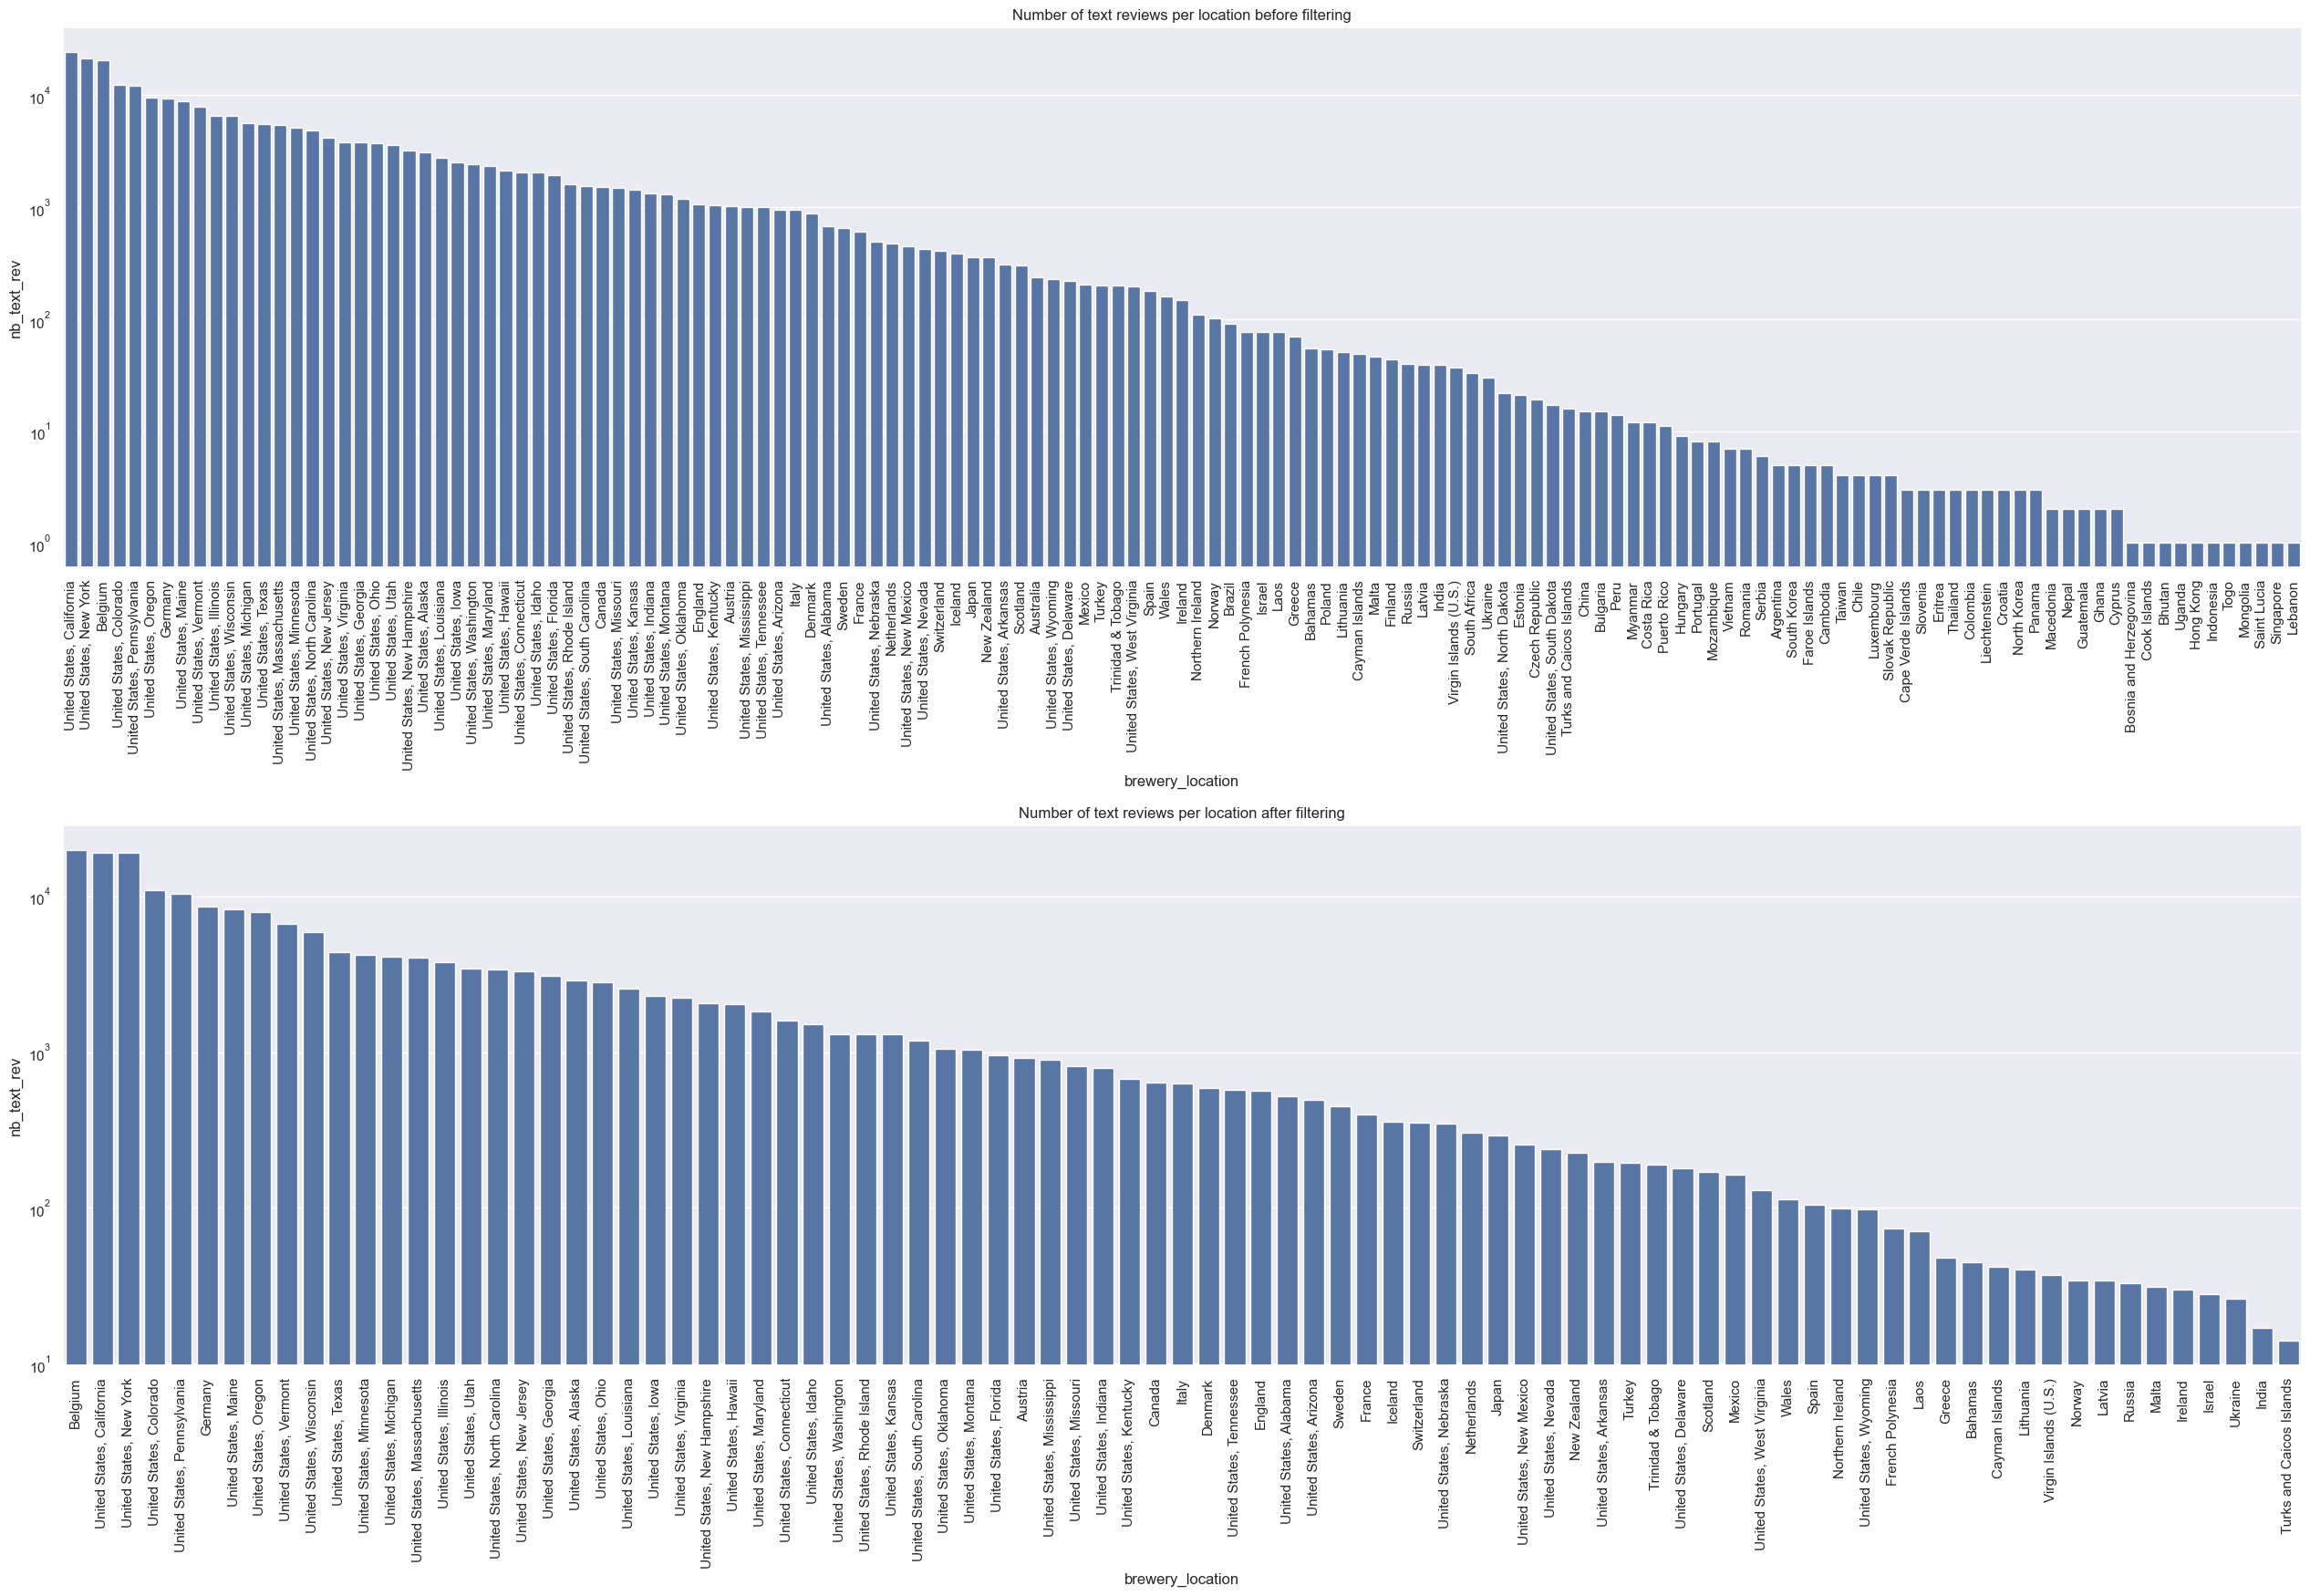

In [17]:
world_ratings = reviews_df.copy()
#drop rows where user_location is NaN   ?
world_ratings = world_ratings.dropna()

#create df with only users from the us
us_users_txt = world_ratings[world_ratings["user_location"].str.contains("United States")]

us_users_txt["user_location"] = [name.replace("United States, ", "") for name in us_users_txt["user_location"]]

#only reviews with text review
us_users_txt = us_users_txt[us_users_txt["text"]!="nan"]

#add climate column where climate is the climate of the state the user is from
us_users_txt["climate"] = us_users_txt["user_location"].map(states_climate["Climate"])

#count number of text reviews per beer

us_users_txt["nb_text_rev"] = us_users_txt.groupby("beer_id")["text"].transform("count")


unique_beers_txt = us_users_txt[["beer_id", "nb_text_rev", "brewery_location"]].copy().drop_duplicates()
total_ratings_txt = unique_beers_txt["nb_text_rev"].sum()

unique_beers_txt = unique_beers_txt.groupby("brewery_location")["nb_text_rev"].sum().sort_values(ascending=False).reset_index()

fig, axs = plt.subplots(2,1,figsize=(30, 20))
fig.tight_layout(pad = 15.0)
sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nb_text_rev", data=unique_beers_txt, orient="v", ax=axs[0])
axs[0].tick_params(axis="x", rotation=90)
axs[0].set_title("Number of text reviews per location before filtering")
axs[0].set(yscale="log")


#only keep beers with more than 10 ratings
us_users_txt = us_users_txt[us_users_txt["nb_text_rev"] > 10]

beers_left_txt = us_users_txt[["beer_id","nb_text_rev", "brewery_location"]].copy().drop_duplicates()

beers_left_txt = beers_left_txt.groupby("brewery_location")["nb_text_rev"].sum().sort_values(ascending=False).reset_index()

ratings_left_txt = beers_left_txt["nb_text_rev"].sum()
print(" Percentage of ratings left: ", ratings_left_txt / total_ratings_txt * 100, "%")

beers_left_txt["Percentage of ratings"] = beers_left_txt["nb_text_rev"] / beers_left_txt["nb_text_rev"].sum() * 100

sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nb_text_rev", data=beers_left_txt, orient="v", ax=axs[1])
axs[1].set_title("Number of text reviews per location after filtering")
axs[1].tick_params(axis="x", rotation=90)
plt.yscale("log")


## 2) First analysis : how beers from one country are rated (reviewed)

We first want to look at how beers from a given country are perceived by users. We start from the full dataframe with all the reviews.

### Data cleaning

Let's first look at distribution of number of reviews

In [18]:
micro_average_ratings = us_users_ratings[columns_compare].mean().sort_values(ascending=False).reset_index()

avg_ratings_per_location = us_users_ratings.groupby("user_location")[columns_compare].mean().sort_values(by="overall", ascending=False).reset_index()
macro_average_ratings = avg_ratings_per_location[columns_compare].mean().sort_values(ascending=False)

# For each score in the columns_compare list, we compute the difference between the state average and the global average
diff_avg = pd.DataFrame()
diff_avg["user_location"] = avg_ratings_per_location["user_location"]
for score in columns_compare:
    diff_avg[score] = avg_ratings_per_location[score] - macro_average_ratings[score]

In [19]:
from scipy.stats import ttest_ind

# Get the list of user location
user_location = diff_avg["user_location"].unique()

t_test_values = diff_avg.copy()
p_values = diff_avg.copy()

# For each unique location, compare each column to compare with the global average using t-test
for state in user_location:
    df_one_state = us_users_ratings[us_users_ratings["user_location"] == state]

    for score in columns_compare:
        t_test = ttest_ind(df_one_state[score], us_users_ratings[score])
        alpha = 0.05
        p_values.loc[p_values["user_location"] == state, score] = True if t_test.pvalue < alpha else False
        t_test_values.loc[t_test_values["user_location"] == state, score] = t_test.statistic
        
t_test_values.set_index("user_location", inplace=True)
p_values.set_index("user_location", inplace=True)

In [20]:
p_values["all_passed"] = p_values[columns_compare].all(axis=1)
p_values["any_passed"] = p_values[columns_compare].any(axis=1)

t_test_values["Climate"] = t_test_values.index.map(states_climate["Climate"])


diff_avg.set_index("user_location", inplace=True)
diff_avg["Climate"] = diff_avg.index.map(states_climate["Climate"])


# Turn climate into a numerical value
climates = t_test_values["Climate"].unique()
for i in range(len(climates)):
    t_test_values["Climate"] = t_test_values["Climate"].replace(climates[i], i)
    diff_avg["Climate"] = diff_avg["Climate"].replace(climates[i], i)
t_test_values.head()

,aroma,appearance,palate,taste,overall,rating,Climate
user_location,,,,,,,
South Dakota,3.408017,2.480453,2.488342,2.481646,2.712539,3.096095,0
Vermont,10.954441,8.089173,10.268152,12.020185,11.130258,12.602494,1
Alaska,4.553525,4.834683,5.461457,4.920948,5.514489,5.603981,2
Maine,8.775664,6.896874,6.586073,10.444432,9.615721,10.451157,1
Utah,1.330892,1.497976,0.932064,1.216826,1.679173,1.491098,1


In [22]:
# Restart from us_users_ratings
rus_users_with_climategression_df = us_users_ratings[["user_location"] + columns_compare].copy()

# Add the climate column 
regression_df["Climate"] = regression_df["user_location"].map(states_climate["Climate"])

climates = regression_df["Climate"].unique()
for i in range(len(climates)):
    regression_df["Climate"] = regression_df["Climate"].replace(climates[i], i)

# Separate the data into training and testing sets
from sklearn.model_selection import train_test_split
X = regression_df[columns_compare]
y = regression_df["Climate"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'regression_df' is not defined

In [ ]:
# Train the model
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

# Get the predictions
y_pred = reg.predict(X_test)

# Get the score
reg.score(X_test, y_test)

0.00010974384681561311

In [ ]:
display(diff_avg.sample(5))

,aroma,appearance,palate,taste,overall,rating,Climate
user_location,,,,,,,
Idaho,-0.163544,-0.216773,-0.177070,-0.159925,-0.203810,-0.174362,9
Maryland,-0.021745,0.000216,0.009874,-0.027666,-0.022216,-0.019855,3
Minnesota,0.021322,0.009252,0.007198,0.009905,0.025327,0.015228,1
Rhode Island,0.029835,0.032670,0.071188,0.034173,0.043713,0.038801,3
Arkansas,-0.071331,-0.137323,-0.035194,-0.028155,0.034015,-0.033430,3


In [ ]:
# Print coefficients of the linear regression
print("Coefficients: ", reg.coef_)

Coefficients:  [-585.20371804 -130.25611219 -240.22175649 -925.68740498 -475.80058256
 2336.69556761]


## 3) Text reviews baseline

Compute the average sentiment analysis score for us users and then average per state

In [25]:
saved = True

def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)  # We use the seed 42

#load spacy model and add pipeline to detect language
nlp_model = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp_model.add_pipe('language_detector', last=True)
nlp_model.add_pipe('spacytextblob')

if saved :
    print("retreiving language of text reviews from csv")
    us_users_txt = pd.read_csv("data/us_users_txt.csv")
else :
    #detect language of text reviews
    us_users_txt["language"] = us_users_txt["text"].apply(lambda x: nlp_model(x)._.language["language"])
    us_users_txt["polarity"] = us_users_txt["text"].apply(lambda x: nlp_model(x)._.blob.polarity)
    us_users_txt["subjectivity"] = us_users_txt["text"].apply(lambda x: nlp_model(x)._.blob.subjectivity)
    us_users_txt.to_csv("data/us_users_txt.csv")
    

In [ ]:
doc = us_users_txt["text"].iloc[0:4]
#detect language of text reviews and see how much time it takes
import time
start_time = time.time()
doc = doc.apply(lambda x: nlp_model(x)._.blob.polarity)
duration = (time.time() - start_time)
print("--- %s seconds ---" % duration)

print(len(us_users_txt["text"]), "duration ", len(us_users_txt["text"])/4/60/60, "heures")
print(doc)

--- 0.14366745948791504 seconds ---
193640 duration  13.447222222222223 heures
7     0.225843
8    -0.114394
12    0.084722
14    0.167949
Name: text, dtype: float64


In [ ]:
#compute sentiment analysis of text reviews
